In [1]:
# basic stuff 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
# from google.colab import files
import os
import sklearn
import time
import math
import itertools

# torch stuff
import torch
from torch import nn
import torch.nn.functional as F

# !pip install mat73
# import mat73

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Miller_Lab/FIU/PopFRData/')
sys.path.append('/content/drive/MyDrive/Miller_Lab/FIU/xds_python/')
sys.path.append('/content/drive/MyDrive/Miller_Lab/FIU/custom_functions/')

from xds import lab_data
import joint_angles
import data_loading
import train_test
import r2_pr2
import pr2
import models
from models import TempConvNet, FCNet
import visualization

Load datasets

In [4]:
tcnn_dataset_dict_split = data_loading.load_datasets('/content/drive/My Drive/Miller_Lab/FIU/PopFRData/tcnn_processed_shuffled_opensim_datasets_splitneurons/instance_length_100/fullyrestrained/',split_neurons = True)
tcnn_loader_dict_split = data_loading.get_loaders(tcnn_dataset_dict_split, 32,split_neurons = True)

In [5]:
tcnn_dataset_dict_split

{'20220309': {'Joint Angles': {'0': {'Full': <data_loading.CustomDataset at 0x7fdeaffde520>,
    'Train': <torch.utils.data.dataset.Subset at 0x7fde7ac44310>,
    'Test': <torch.utils.data.dataset.Subset at 0x7fde7ac447f0>},
   '1': {'Full': <data_loading.CustomDataset at 0x7fde7aba1fa0>,
    'Train': <torch.utils.data.dataset.Subset at 0x7fde7ad770a0>,
    'Test': <torch.utils.data.dataset.Subset at 0x7fde7ad77190>},
   '2': {'Full': <data_loading.CustomDataset at 0x7fde7ad772b0>,
    'Train': <torch.utils.data.dataset.Subset at 0x7fde7ad77310>,
    'Test': <torch.utils.data.dataset.Subset at 0x7fde7ad77400>}}},
 '20210712': {'Joint Angles': {'0': {'Full': <data_loading.CustomDataset at 0x7fde7ad77520>,
    'Train': <torch.utils.data.dataset.Subset at 0x7fde7ad77580>,
    'Test': <torch.utils.data.dataset.Subset at 0x7fde7ad77700>},
   '1': {'Full': <data_loading.CustomDataset at 0x7fde7ad778e0>,
    'Train': <torch.utils.data.dataset.Subset at 0x7fdd2d195cd0>,
    'Test': <torch.util

In [6]:
all_dataset_permutations = list(itertools.permutations(tcnn_dataset_dict_split))

In [7]:
len(all_dataset_permutations)

120

In [16]:
def plot_losses_transfer_learning_TCN(dataset_dict, loader_dict, num_permutations, init_lr, lr_factor, num_epochs = 101):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    all_dataset_permutations = list(itertools.permutations(dataset_dict))
    split_perms = list(itertools.permutations(['0','1','2']))
    split_list = [item for tuple in split_perms for item in tuple]

    perm_nums = np.random.randint(low=0, high=len(all_dataset_permutations), size=num_permutations)
    perm_nums[0]=0

    models = {}
    losses = {'All Losses': {},'By Dataset': {}}
    losses['All Losses'][lr_factor] = {'Train': [], 'Test': []}
    losses['By Dataset'][lr_factor] = {'Train': {},'Test': {}}
    for date in loader_dict.keys():
        for train_test_str in losses['By Dataset'][lr_factor].keys():
            losses['By Dataset'][lr_factor][train_test_str][date] = {'0':[],'1':[],'2':[]}
    
    date0 = list(loader_dict.keys())[0]
    output_dim = tcnn_dataset_dict_split[date0]['Joint Angles']['0']['Full'].num_neural_units
    model = TempConvNet(24, output_dim, 3, 1, 5, 2, add_relu = True, causal=True).to(device)

    # get randomly initialized linear layers

    linear_layers = {}
    for date in tcnn_dataset_dict_split.keys():
        linear_layers[date] = {}
        for split in split_list:
            output_dim = tcnn_dataset_dict_split[date]['Joint Angles'][split]['Full'].num_neural_units
            m = TempConvNet(24, output_dim, 3, 1, 5, 2, add_relu = True, causal=True).to(device)
            linear_layers[date][split] = m.net[-2]

    for iteration, (split, perm_num) in enumerate(zip(split_list, perm_nums)):
        perm = all_dataset_permutations[perm_num]
        for i, date in enumerate(perm):
            print(date, split)
            
            model.net[-2] = linear_layers[date][split]

            train_loader, test_loader, full_dataset = \
                tcnn_loader_dict_split[date]['Joint Angles'][split]['Train'], \
                tcnn_loader_dict_split[date]['Joint Angles'][split]['Test'], \
                tcnn_dataset_dict_split[date]['Joint Angles'][split]['Full']

            print(date, split, model.net[-2],full_dataset.num_neural_units)

            lr = init_lr*(lr_factor**(iteration))
            criterion = torch.nn.MSELoss()
            optimizer = torch.optim.Adam([
                {'params': model.net[0].parameters(), 'lr': lr},
                {'params': model.net[2].parameters(), 'lr': lr},
                {'params': model.net[4].parameters(), 'lr': lr},
                {'params': model.net[6].parameters(), 'lr': 0.001}])
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=8, min_lr=0.0)   
            total_params = sum(p.numel() for p in model.parameters())

            print('Date: {}, Split: {}, Initial LR: {} '.format(date,split,lr))
            print('Num Conv Layers: {}, Total Parameters: {}'\
                .format(model.num_conv_layers, total_params))

            start = time.time()
            for epoch in range(num_epochs):
                lr = scheduler.optimizer.param_groups[0]['lr']
                train_loss = train_test.train(train_loader, model, optimizer, criterion, scheduler, conv = True)
                _, train_R2, train_pr2, train_preds, train_targets = train_test.test(train_loader, model, optimizer, criterion, full_dataset.num_neural_units, conv = True)
                test_loss, test_R2, test_pr2, test_preds, test_targets = train_test.test(test_loader, model, optimizer, criterion, full_dataset.num_neural_units, conv = True)
                scheduler.step(test_loss)
                if epoch % 50==0:
                  print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:7f}, Test Loss: {:7f}. Train R2: {:.7f}, Test R2: {:.7f}, Train pR2: {:.7f}, Test pR2: {:.7f}'\
                      .format(epoch, lr, train_loss, test_loss, train_R2, test_R2, train_pr2, test_pr2))

                losses['All Losses'][lr_factor]['Train'].append(train_loss)
                losses['All Losses'][lr_factor]['Test'].append(test_loss)
                losses['By Dataset'][lr_factor]['Train'][date][split].append(train_loss)
                losses['By Dataset'][lr_factor]['Test'][date][split].append(test_loss)

            end = time.time()
            print('Time to train model: {}'.format(end-start))
            plt.plot(losses['By Dataset'][lr_factor]['Train'][date][split])
            plt.plot(losses['By Dataset'][lr_factor]['Test'][date][split])
            plt.title('Losses - Date: {}, Split: {}, Num Conv Layers: {}'.format(date, split, model.num_conv_layers))
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend(['Train Losses', 'Test Losses'])
            plt.show()

            # replace linear layer with most recently trained
            linear_layers[date][split] = model.net[-2]

20220309 0
20220309 0 Linear(in_features=192, out_features=32, bias=True) 32
Date: 20220309, Split: 0, Initial LR: 0.001 
Num Conv Layers: 3, Total Parameters: 127472
Epoch: 000, LR: 0.001000, Train Loss: 403.374072, Test Loss: 249.828499. Train R2: -1.7539957, Test R2: -1.7472265, Train pR2: -22.3096409, Test pR2: -23.0423031
Epoch: 050, LR: 0.001000, Train Loss: 58.743233, Test Loss: 61.036467. Train R2: 0.4023282, Test R2: 0.3179913, Train pR2: -0.3083898, Test pR2: -0.3929257
Epoch: 100, LR: 0.000410, Train Loss: 53.081049, Test Loss: 59.975567. Train R2: 0.4554856, Test R2: 0.3407310, Train pR2: -0.2589392, Test pR2: -0.3626876
Time to train model: 8.805158615112305


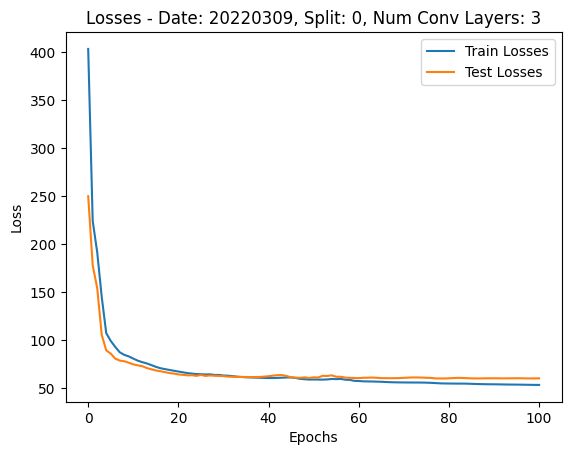

20210712 0
20210712 0 Linear(in_features=192, out_features=47, bias=True) 47
Date: 20210712, Split: 0, Initial LR: 0.001 
Num Conv Layers: 3, Total Parameters: 130367
Epoch: 000, LR: 0.001000, Train Loss: 274.497357, Test Loss: 179.628576. Train R2: -0.5040393, Test R2: -0.4995546, Train pR2: -10.1219139, Test pR2: -10.1404552


KeyboardInterrupt: ignored

In [18]:
plot_losses_transfer_learning_TCN(tcnn_dataset_dict_split, tcnn_loader_dict_split, 18)

In [11]:
list(tcnn_loader_dict_split.keys())

['20220309', '20210712', '20211105', '20210710', '20210814']

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

init_lr = 0.001
lr_factor = 0.7

split_perms = list(itertools.permutations(['0','1','2']))
split_list = [item for tuple in split_perms for item in tuple]

perm_nums = np.random.randint(low=0, high=120, size=18)
perm_nums[0]=0

losses = {'All Losses': {},'By Dataset': {}}
models = {}


losses['All Losses'][lr_factor] = {'Train': [], 'Test': []}
losses['By Dataset'][lr_factor] = {'Train': {'20220309': {'0':[],'1':[],'2':[]}, '20210712': {'0':[],'1':[],'2':[]}, '20211105': {'0':[],'1':[],'2':[]}, '20210710': {'0':[],'1':[],'2':[]}, '20210814': {'0':[],'1':[],'2':[]}},\
                                    'Test': {'20220309': {'0':[],'1':[],'2':[]}, '20210712': {'0':[],'1':[],'2':[]}, '20211105': {'0':[],'1':[],'2':[]}, '20210710': {'0':[],'1':[],'2':[]}, '20210814': {'0':[],'1':[],'2':[]}}}

In [ ]:
output_dim = tcnn_dataset_dict_split['20220309']['Joint Angles']['0']['Full'].num_neural_units
model = TempConvNet(24, output_dim, 3, 1, 5, 2, add_relu = True, causal=True).to(device)

# get randomly initialized linear layers

linear_layers = {}
for date in tcnn_dataset_dict_split.keys():
    linear_layers[date] = {}
    for split in split_list:
        output_dim = tcnn_dataset_dict_split[date]['Joint Angles'][split]['Full'].num_neural_units
        m = TempConvNet(24, output_dim, 3, 1, 5, 2, add_relu = True, causal=True).to(device)
        linear_layers[date][split] = m.net[-2]

In [ ]:
for iteration, (split, perm_num) in enumerate(zip(split_list, perm_nums)):
    perm = all_dataset_permutations[perm_num]
    for i, date in enumerate(perm):
        print(date, split)
        
        model.net[-2] = linear_layers[date][split]

        train_loader, test_loader, full_dataset = \
            tcnn_loader_dict_split[date]['Joint Angles'][split]['Train'], \
            tcnn_loader_dict_split[date]['Joint Angles'][split]['Test'], \
            tcnn_dataset_dict_split[date]['Joint Angles'][split]['Full']

        print(date, split, model.net[-2],full_dataset.num_neural_units)

        lr = init_lr*(lr_factor**(iteration))
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam([
            {'params': model.net[0].parameters(), 'lr': lr},
            {'params': model.net[2].parameters(), 'lr': lr},
            {'params': model.net[4].parameters(), 'lr': lr},
            {'params': model.net[6].parameters(), 'lr': 0.001}])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=8, min_lr=0.0)   
        total_params = sum(p.numel() for p in model.parameters())

        print('Date: {}, Split: {}, Initial LR: {} '.format(date,split,lr))
        print('Num Conv Layers: {}, Total Parameters: {}'\
            .format(model.num_conv_layers, total_params))

        start = time.time()
        for epoch in range(101):
            lr = scheduler.optimizer.param_groups[0]['lr']
            train_loss = train_test.train(train_loader, model, optimizer, criterion, scheduler, conv = True)
            _, train_R2, train_pr2, train_preds, train_targets = train_test.test(train_loader, model, optimizer, criterion, full_dataset.num_neural_units, conv = True)
            test_loss, test_R2, test_pr2, test_preds, test_targets = train_test.test(test_loader, model, optimizer, criterion, full_dataset.num_neural_units, conv = True)
            scheduler.step(test_loss)
            if epoch % 50==0:
              print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:7f}, Test Loss: {:7f}. Train R2: {:.7f}, Test R2: {:.7f}, Train pR2: {:.7f}, Test pR2: {:.7f}'\
                  .format(epoch, lr, train_loss, test_loss, train_R2, test_R2, train_pr2, test_pr2))

            losses['All Losses'][lr_factor]['Train'].append(train_loss)
            losses['All Losses'][lr_factor]['Test'].append(test_loss)
            losses['By Dataset'][lr_factor]['Train'][date][split].append(train_loss)
            losses['By Dataset'][lr_factor]['Test'][date][split].append(test_loss)

        end = time.time()
        print('Time to train model: {}'.format(end-start))
        plt.plot(losses['By Dataset'][lr_factor]['Train'][date][split])
        plt.plot(losses['By Dataset'][lr_factor]['Test'][date][split])
        plt.title('Losses - Date: {}, Split: {}, Num Conv Layers: {}'.format(date, split, model.num_conv_layers))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(['Train Losses', 'Test Losses'])
        plt.show()

        # replace linear layer with most recently trained
        linear_layers[date][split] = model.net[-2]

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model_save_dir = '/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/Pop_FR_OpenSIM/TransferLearning/SplitNeurons/07/core_model'
torch.save(model.net[:-2].state_dict(), model_save_dir)

In [ ]:
for date in linear_layers.keys():
  for split in linear_layers[date]:
    model_save_dir = '/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/Pop_FR_OpenSIM/TransferLearning/SplitNeurons/07/{}/{}/transfer_layer'.format(date,split)
    torch.save(linear_layers[date][split].state_dict(), model_save_dir)

In [ ]:
os.path.isdir('/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/Pop_FR_OpenSIM/TransferLearning/SplitNeurons/095/')

False

In [ ]:
base_dir = '/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/Pop_FR_OpenSIM/Standard/SplitNeurons/instance_length_100/mse_loss/fullyrestrained/'
standard_tcn_dict = {}
for date in os.listdir(base_dir):
    standard_tcn_dict[date] = {}
    for split_num in os.listdir(os.path.join(base_dir,date)):
        cnn_3convlayers_add_relu = TempConvNet(24, tcnn_dataset_dict_split[date]['Joint Angles'][split_num]['Full'].num_neural_units, 3, 1, 5, 2, add_relu = True, causal=False)
        cnn_3convlayers_add_relu.load_state_dict(torch.load(os.path.join(base_dir,date,split_num,'TempCNN_Joint Angles_3_convlayers_reluadded')))
        standard_tcn_dict[date][split_num] = cnn_3convlayers_add_relu

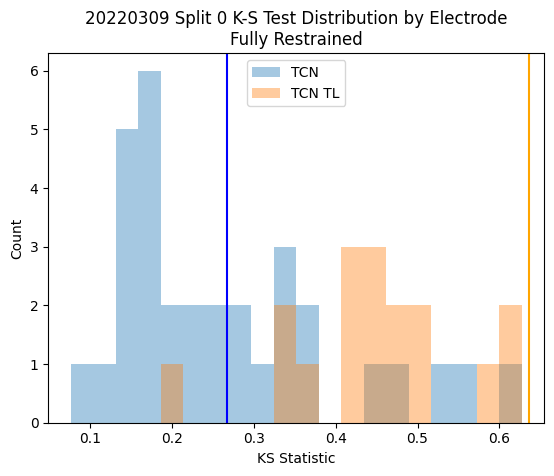

Mean KS TCN: 0.2669910714285714, Mean KS TCN TL: 0.6367499999999999


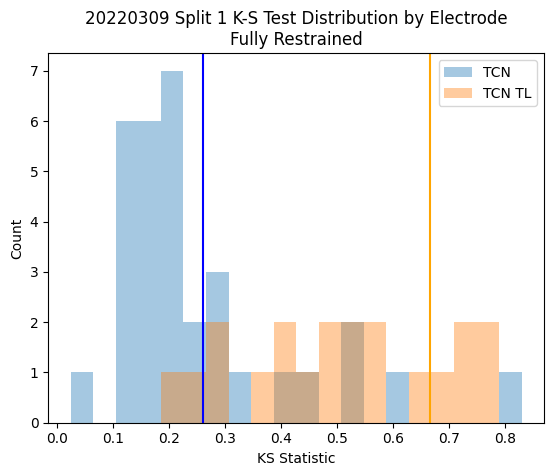

Mean KS TCN: 0.26031249999999995, Mean KS TCN TL: 0.6654553571428572


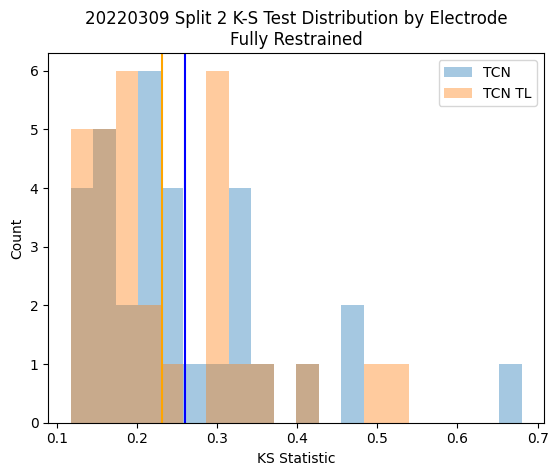

Mean KS TCN: 0.259625, Mean KS TCN TL: 0.23192857142857143


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 100, 47])) that is different to the input size (torch.Size([32, 100, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

In [ ]:
for date in linear_layers.keys():
    for split_num in linear_layers[date]:
        model.net[-2] = linear_layers[date][split]

        model_1_name = 'TCN'
        model1 = standard_tcn_dict[date][split_num]
        dataset1 = tcnn_dataset_dict_split[date]['Joint Angles'][split_num]['Full']
        test_loader1 = tcnn_loader_dict_split[date]['Joint Angles'][split_num]['Test']
        conv1 = True

        model_2_name = 'TCN TL'
        model2 = model
        dataset2 = tcnn_dataset_dict_split[date]['Joint Angles'][split_num]['Full']
        test_loader2 = tcnn_loader_dict_split[date]['Joint Angles'][split_num]['Test']
        conv2 = True
        
        mean_model_1, mean_model_2 = visualization.plot_and_compare_ks(model_1_name, model1, dataset1, test_loader1, conv1, model_2_name, model2, dataset2, test_loader2, conv2, 'Fully Restrained', bins = 20)
        print('Mean KS TCN: {}, Mean KS TCN TL: {}'.format(mean_model_1, mean_model_2))

In [ ]:
for date in linear_layers.keys():
    for split_num in linear_layers[date].keys():
        model.net[-2] = linear_layers[date][split_num]
        # model1 = standard_tcn_dict[date][split_num]

        # print(model.output_dim, model1.output_dim)
        print(model.output_dim)

32
32
32
32
32
32
32
32
32
32
32
32
32
32
32


In [ ]:
linear_layers

{'20220309': {'0': Linear(in_features=192, out_features=32, bias=True),
  '1': Linear(in_features=192, out_features=32, bias=True),
  '2': Linear(in_features=192, out_features=32, bias=True)},
 '20210712': {'0': Linear(in_features=192, out_features=47, bias=True),
  '1': Linear(in_features=192, out_features=47, bias=True),
  '2': Linear(in_features=192, out_features=48, bias=True)},
 '20211105': {'0': Linear(in_features=192, out_features=37, bias=True),
  '1': Linear(in_features=192, out_features=37, bias=True),
  '2': Linear(in_features=192, out_features=39, bias=True)},
 '20210710': {'0': Linear(in_features=192, out_features=51, bias=True),
  '1': Linear(in_features=192, out_features=51, bias=True),
  '2': Linear(in_features=192, out_features=51, bias=True)},
 '20210814': {'0': Linear(in_features=192, out_features=48, bias=True),
  '1': Linear(in_features=192, out_features=48, bias=True),
  '2': Linear(in_features=192, out_features=49, bias=True)}}

In [ ]:
for date in linear_layers.keys():
    for split_num in linear_layers[date].keys():
        model.net[-2] = linear_layers[date][split_num]
        model1 = standard_tcn_dict[date][split_num]
        print(linear_layers[date][split_num].out_features, model1.output_dim, tcnn_dataset_dict_split[date]['Joint Angles'][split_num]['Full'].num_neural_units)
        print(model1,model)

32 32 32
TempConvNet(
  (net): ModuleList(
    (0): Conv1d(24, 48, kernel_size=(5,), stride=(1,), padding=same)
    (1): ReLU()
    (2): Conv1d(48, 96, kernel_size=(5,), stride=(1,), padding=same)
    (3): ReLU()
    (4): Conv1d(96, 192, kernel_size=(5,), stride=(1,), padding=same)
    (5): ReLU()
    (6): Linear(in_features=192, out_features=32, bias=True)
    (7): ReLU()
  )
) TempConvNet(
  (net): ModuleList(
    (0): Conv1d(24, 48, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(48, 96, kernel_size=(5,), stride=(1,))
    (3): ReLU()
    (4): Conv1d(96, 192, kernel_size=(5,), stride=(1,))
    (5): ReLU()
    (6): Linear(in_features=192, out_features=32, bias=True)
    (7): ReLU()
  )
)
32 32 32
TempConvNet(
  (net): ModuleList(
    (0): Conv1d(24, 48, kernel_size=(5,), stride=(1,), padding=same)
    (1): ReLU()
    (2): Conv1d(48, 96, kernel_size=(5,), stride=(1,), padding=same)
    (3): ReLU()
    (4): Conv1d(96, 192, kernel_size=(5,), stride=(1,), padding=same)
    

TCN average pR2: -0.42058485746383667
TCN TL average pR2: -17.3950252532959


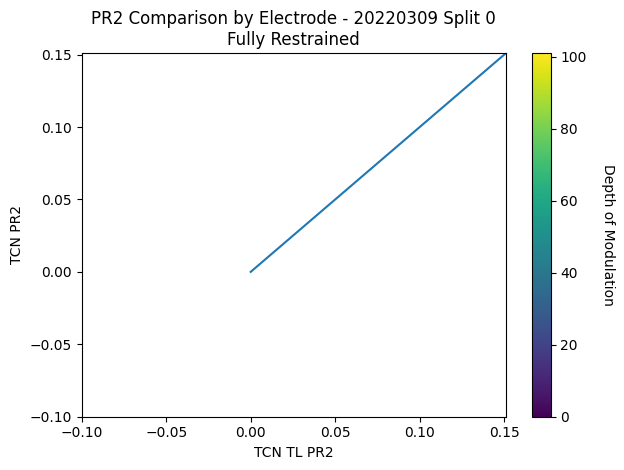

TCN average pR2: -0.7392049431800842
TCN TL average pR2: -18.280651092529297


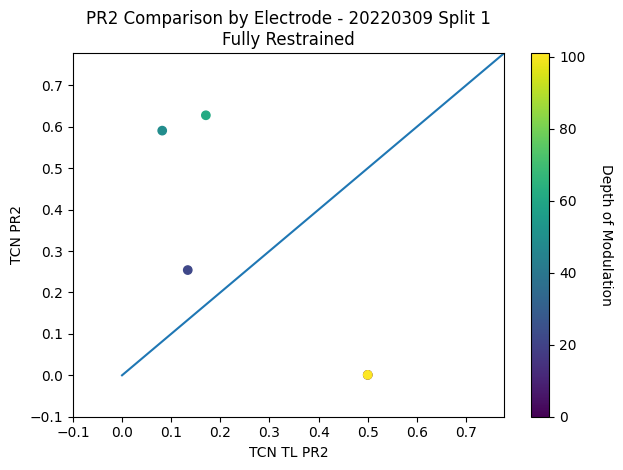

TCN average pR2: -0.20873765647411346
TCN TL average pR2: -0.839176595211029


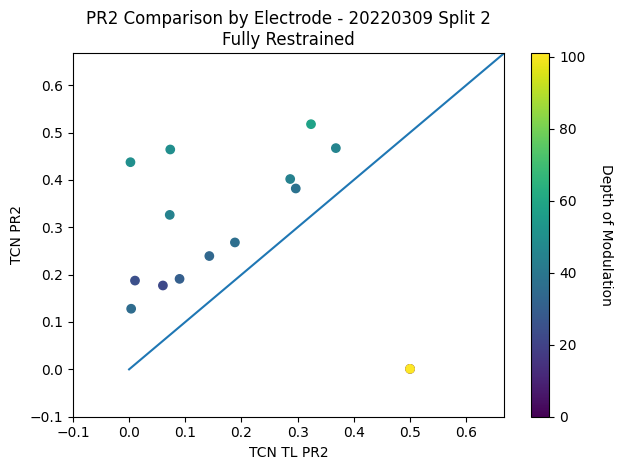

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 100, 47])) that is different to the input size (torch.Size([32, 100, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

In [ ]:
for date in linear_layers.keys():
    for split_num in linear_layers[date]:
        model.net[-2] = linear_layers[date][split]

        model_1_name = 'TCN'
        model1 = standard_tcn_dict[date][split_num]
        dataset1 = tcnn_dataset_dict_split[date]['Joint Angles'][split_num]['Full']
        test_loader1 = tcnn_loader_dict_split[date]['Joint Angles'][split_num]['Test']
        conv1 = True

        model_2_name = 'TCN TL'
        model2 = model
        dataset2 = tcnn_dataset_dict_split[date]['Joint Angles'][split_num]['Full']
        test_loader2 = tcnn_loader_dict_split[date]['Joint Angles'][split_num]['Test']
        conv2 = True
        
        visualization.compare_pr2_plots(model_1_name, model1, dataset1, test_loader1, conv1, model_2_name, model2, dataset2, test_loader2, conv2, 'Fully Restrained', exclude_bad_neurons = True)
        # print('Mean KS TCN: {}, Mean KS MLP: {}'.format(mean_model_1, mean_model_2))